In [1]:
import matplotlib.pyplot as plt, pandas as pd, transforms as T
import argparse, os, torch, json
import numpy as np, random, torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from constants import *
from torchvision import transforms
from dataset import PhotoLoadingDataset
from torch.utils.data import DataLoader
from model import model_registry
from dataset import transforms_registry
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
log_folder = input("Log folder: ")
args = argparse.Namespace()
args_file = os.path.join(log_folder, LOGS_ARGS_FILE_NAME)
with open(args_file, "r") as f:
    args.__dict__ = json.load(f)


In [3]:
transforms = transforms_registry["test"](args.input_size)

selected_folders_df = pd.read_csv(SELECTED_FOLDERS_FOR_MODEL)
selected_folders = selected_folders_df["folder"].astype(str).tolist()

dataset = PhotoLoadingDataset(FORMATTED_PHOTO_FOLDER, selected_folders, transform=transforms)
dataloader = DataLoader(dataset, batch_size=50, shuffle=True)

In [4]:
model = model_registry[args.model]().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.load_state_dict(torch.load(os.path.join(log_folder, LOGS_MODEL_FILE_NAME)))
optimizer.load_state_dict(torch.load(os.path.join(log_folder, LOGS_OPTIMIZER_FILE_NAME)))

model.eval()
print("Model loaded")

Model loaded


In [11]:
embeddings = []
labels = []
images = []
for i, (x, y) in enumerate(dataloader):
    x = x.to(device)
    y = [int(y_) for y_ in y]
    y = torch.tensor(y).to(device)   
    with torch.no_grad():
        output = model(x)
        embeddings.append(output)
        labels.append(y)
        images.append(x)
        

embeddings = torch.cat(embeddings, dim=0)
embeddings = embeddings.cpu().numpy()

labels = torch.cat(labels, dim=0)
labels = labels.cpu().numpy()

images = torch.cat(images, dim=0)
images = images.cpu().numpy()

print(f"Total number of samples: {len(labels)}")
print(f"Number of unique labels: {len(np.unique(labels))}")

Total number of samples: 2648
Number of unique labels: 154


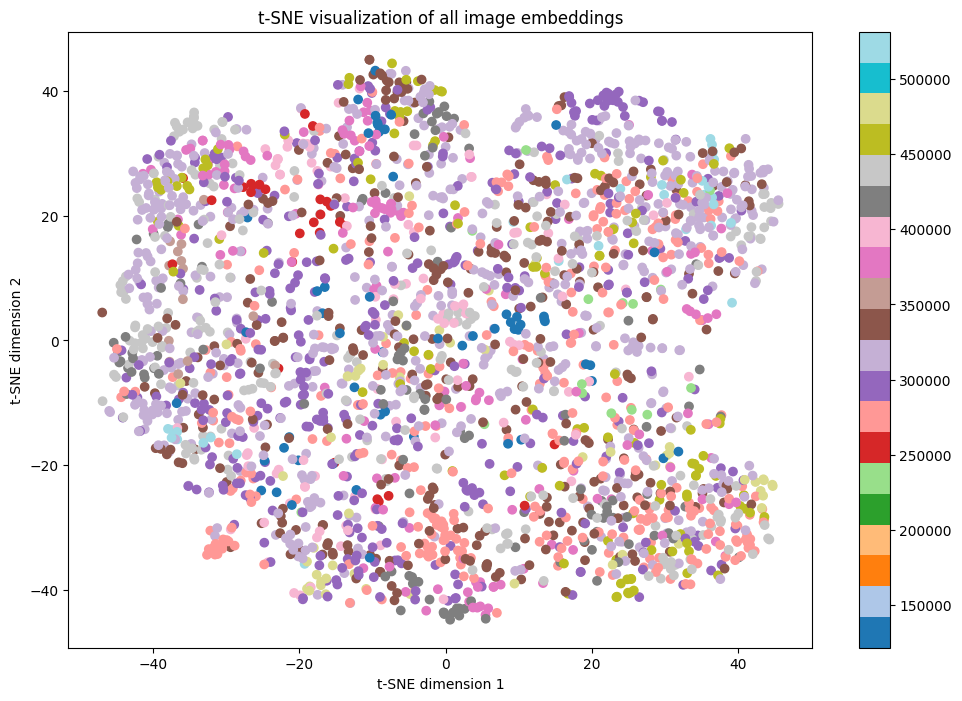

In [12]:
# Import t-SNE for dimensionality reduction
from sklearn.manifold import TSNE

# Reduce dimensions to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Create a scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab20')
plt.colorbar(scatter)
plt.title('t-SNE visualization of all image embeddings')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

In [17]:
from PIL import Image
import numpy as np
from collections import Counter

# Get image path from user
image_path = input("Enter the path to your image: ")

# Load and preprocess the image
image = Image.open(image_path)
image_tensor = transforms(image).unsqueeze(0).to(device)

# Get embedding for the input image
model.eval()
with torch.no_grad():
    input_embedding = model(image_tensor)
    input_embedding = input_embedding.cpu().numpy()

# Calculate Euclidean distances to all embeddings
distances = np.linalg.norm(embeddings - input_embedding, axis=1)

# Get indices of 20 nearest neighbors
nearest_indices = np.argsort(distances)[:40]

# Get labels of nearest neighbors
nearest_labels = labels[nearest_indices]

# Count frequency of each label
label_counts = Counter(nearest_labels)

# Get the 4 most common labels
most_common_labels = label_counts.most_common(4)

print("\nMost frequent labels among 20 nearest neighbors:")
for i, (label, count) in enumerate(most_common_labels, 1):
    print(f"{i}. Label {label} (found {count} times)")

# Print distances for verification
print("\nDistances to the nearest neighbors with these labels:")
for label, _ in most_common_labels:
    # Find the closest distance for this label
    label_distances = distances[labels == label]
    if len(label_distances) > 0:
        min_distance = np.min(label_distances)
        print(f"Label {label}: {min_distance:.4f}")


Most frequent labels among 20 nearest neighbors:
1. Label 282109 (found 8 times)
2. Label 280545 (found 6 times)
3. Label 438218 (found 5 times)
4. Label 278918 (found 4 times)

Distances to the nearest neighbors with these labels:
Label 282109: 3.1777
Label 280545: 3.5749
Label 438218: 0.0306
Label 278918: 4.0276
